# Bioconductor Workflows - RNAseq (Jupyter notebook)

Here we walk through an end-to-end gene-level RNA-seq differential expression workflow using Bioconductor packages. We will start from the FASTQ files, show how these were aligned to the reference genome, and prepare a count matrix which tallies the number of RNA-seq reads/fragments within each gene for each sample. We will perform exploratory data analysis (EDA) for quality assessment and to explore the relationship between samples, perform differential gene expression analysis, and visually explore the results.

In [1]:
# Loading the requisite libraries
# source("https://bioconductor.org/biocLite.R")
# biocLite()
suppressPackageStartupMessages(library("BiocStyle"))

suppressPackageStartupMessages(library("knitr"))

suppressPackageStartupMessages(library("rmarkdown"))

# to hide warnings
options(warm = 0)

opts_chunk$set(message = FALSE, error = FALSE, warning = FALSE,
               cache = TRUE, fig.width = 5, fig.height = 5)

## Loading airway smooth muscle cell package package
library("airway")

## Specifying external directory for the bioconductor package
indir <- system.file("extdata", package="airway", mustWork=TRUE)
print("List of Files in the /extdata directory of the airway package:")
list.files(indir)

Bioconductor version 3.4 (BiocInstaller 1.24.0), ?biocLite for help
A new version of Bioconductor is available after installing the most recent
  version of R; see http://bioconductor.org/install
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.4 (BiocInstaller 1.24.0), R 3.3.2 (2016-10-31).
installation path not writeable, unable to update packages: foreign
Old packages: 'curl', 'formatR', 'Hmisc', 'htmltools', 'Matrix', 'rmarkdown',
  'shiny', 'XML'
Warning message:
"package 'rmarkdown' was built under R version 3.3.3"Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Warning message:
"package 'GenomicRanges' was built under R version 3.3.3"Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply,

[1] "List of Files in the /extdata directory of the airway package:"


[1] "GSE52778_series_matrix.txt"        "Homo_sapiens.GRCh37.75_subset.gtf"
 [3] "sample_table.csv"                  "SraRunInfo_SRP033351.csv"         
 [5] "SRR1039508_subset.bam"             "SRR1039509_subset.bam"            
 [7] "SRR1039512_subset.bam"             "SRR1039513_subset.bam"            
 [9] "SRR1039516_subset.bam"             "SRR1039517_subset.bam"            
[11] "SRR1039520_subset.bam"             "SRR1039521_subset.bam"

In [2]:
# accessing the sample table from the airway package.
csvfile <- file.path(indir, "sample_table.csv")
sampleTable <- read.csv(csvfile, row.names = 1)
sampleTable

,SampleName,cell,dex,albut,Run,avgLength,Experiment,Sample,BioSample
SRR1039508,GSM1275862,N61311,untrt,untrt,SRR1039508,126,SRX384345,SRS508568,SAMN02422669
SRR1039509,GSM1275863,N61311,trt,untrt,SRR1039509,126,SRX384346,SRS508567,SAMN02422675
SRR1039512,GSM1275866,N052611,untrt,untrt,SRR1039512,126,SRX384349,SRS508571,SAMN02422678
SRR1039513,GSM1275867,N052611,trt,untrt,SRR1039513,87,SRX384350,SRS508572,SAMN02422670
SRR1039516,GSM1275870,N080611,untrt,untrt,SRR1039516,120,SRX384353,SRS508575,SAMN02422682
SRR1039517,GSM1275871,N080611,trt,untrt,SRR1039517,126,SRX384354,SRS508576,SAMN02422673
SRR1039520,GSM1275874,N061011,untrt,untrt,SRR1039520,101,SRX384357,SRS508579,SAMN02422683
SRR1039521,GSM1275875,N061011,trt,untrt,SRR1039521,98,SRX384358,SRS508580,SAMN02422677


Once the reads have been aligned, there are a number of tools that can be used to count the number of reads/fragments that can be assigned to genomic features for each sample. These often take as input SAM/BAM alignment files and a file specifying the genomic features, e.g. a GFF3 or GTF file specifying the gene models

In [3]:
## Checking for the existance of files in the package directory.
filenames <- file.path(indir, paste0(sampleTable$Run, "_subset.bam"))
unique(sampleTable$Run)
file.exists(filenames)

[1] SRR1039508 SRR1039509 SRR1039512 SRR1039513 SRR1039516 SRR1039517 SRR1039520
[8] SRR1039521
8 Levels: SRR1039508 SRR1039509 SRR1039512 SRR1039513 ... SRR1039521

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

## Alignment Step:


In [2]:
# Installing requisite packages.

# using SRA(Sequence read archive) toolkit and it's fastq-dump funciton 
 ## Donwload and unpack for x64 bit system
system(" wget 'http://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-centos_linux64.tar.gz' ", intern=TRUE)

system(" tar -xzf sratoolkit.current-centos_linux64.tar.gz", intern=TRUE)

## Use the toolkit by "./fastq-dump"
## help docs: https://ncbi.github.io/sra-tools/install_config.html

ERROR: Error in system(" wget 'http://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-centos_linux64.tar.gz' ", : 'wget' not found


#### Downloading the fastq files in the local directory

In [ ]:
# Downloading Raw fastQ files SRR10395__ 08,09,12,13,116,17,20,21 in th efastQ directory

system("mkdir fastq", intern=TRUE)
system("cd fastq", intern=TRUE)

# SRR--08
system("wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR103/008/SRR1039508/SRR1039508_1.fastq.gz", intern=TRUE)
system("wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR103/008/SRR1039508/SRR1039508_2.fastq.gz", intern=TRUE)

# SRR--09
system("wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR103/009/SRR1039509/SRR1039509_1.fastq.gz", intern=TRUE)
system("wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR103/009/SRR1039509/SRR1039509_2.fastq.gz", intern=TRUE)

# SRR--12
system("wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR103/002/SRR1039512/SRR1039512_1.fastq.gz", intern=TRUE)
system("wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR103/002/SRR1039512/SRR1039512_2.fastq.gz", intern=TRUE)

# SRR--13
system("wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR103/003/SRR1039513/SRR1039513_1.fastq.gz", intern=TRUE)
system("wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR103/003/SRR1039513/SRR1039513_2.fastq.gz", intern=TRUE)

# SRR--16
system("wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR103/006/SRR1039516/SRR1039516_1.fastq.gz", intern=TRUE)
system("wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR103/006/SRR1039516/SRR1039516_2.fastq.gz", intern=TRUE)

# SRR--17
system("wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR103/007/SRR1039517/SRR1039517_1.fastq.gz", intern=TRUE)
system("wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR103/007/SRR1039517/SRR1039517_2.fastq.gz", intern=TRUE)


# SRR--20
system("wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR103/000/SRR1039520/SRR1039520_1.fastq.gz", intern=TRUE)
system("wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR103/000/SRR1039520/SRR1039520_2.fastq.gz", intern=TRUE)

# SRR--21
system("wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR103/001/SRR1039521/SRR1039521_1.fastq.gz", intern=TRUE)
system("wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR103/001/SRR1039521/SRR1039521_2.fastq.gz", intern=TRUE)

system("cd ..", intern=TRUE)

#### Alignment step using the star aligner

In [ ]:
## Installing STAR
 ## Using the source code.
system("git clone https://github.com/alexdobin/STAR ", intern=TRUE)

 ## Installing STAR
system("sudo apt install rna-star", intern=TRUE)
## for .gz comperessed files use --readFilesCommand zcat

system("wget 'https://github.com/yasht7/RNAseq-Workdlow-CaseStudy/blob/master/files.txt' ", intern=TRUE)

# Producing the BAM output(Unsorted) 
system("for f in `cat files.txt`; do STAR --genomeDir ../STAR/ENSEMBL.homo_sapiens.release-75 \
--readFilesCommand zcat fastq/$f\_1.fastq.gz fastq/$f\_2.fastq.gz \
--runThreadN 12 outSAMtype BAM Unsorted 
--outFileNamePrefix aligned/$f.; done", intern=TRUE)

**DESeq2 import functions**

The following tools can be used generate count matrices: summarizeOverlaps (Lawrence et al. 2013), featureCounts (Liao, Smyth, and Shi 2014), tximport (Soneson, Love, and Robinson 2015), htseq-count (Anders, Pyl, and Huber 2015).


| **function** | **package** | **framework** | **output** | **DESeq2 input function** |
|---|---|---|---|---|
| summarizeOverlaps | GenomicAlignments | R/Bioconductor | SummarizedExperiment | DESeqDataSet |
| featureCounts | Rsubread | R/Bioconductor | matrix | DESeqDataSetFromMatrix |
| tximport | tximport | R/Bioconductor | list of matrices | DESeqDataSetFromTximport |
| htseq-count | HTSeq | Python | files | DESeqDataSetFromHTSeq |

We now proceed using summarizeOverlaps. Using the Run column in the sample table, we construct the full paths to the files we want to perform the counting operation on:

In [4]:
## Bam files list from the Rsamtools package

suppressPackageStartupMessages(library("Rsamtools"))

bamfiles <- BamFileList(filenames, yieldSize=2000000)

## The sequence Info
seqinfo(bamfiles[1])

Warning message:
"package 'Rsamtools' was built under R version 3.3.3"Warning message:
"package 'XVector' was built under R version 3.3.3"

Seqinfo object with 84 sequences from an unspecified genome:
  seqnames   seqlengths isCircular genome
  1           249250621       <NA>   <NA>
  10          135534747       <NA>   <NA>
  11          135006516       <NA>   <NA>
  12          133851895       <NA>   <NA>
  13          115169878       <NA>   <NA>
  ...               ...        ...    ...
  GL000210.1      27682       <NA>   <NA>
  GL000231.1      27386       <NA>   <NA>
  GL000229.1      19913       <NA>   <NA>
  GL000226.1      15008       <NA>   <NA>
  GL000207.1       4262       <NA>   <NA>

**Note:** 
Make sure that the chromosome names of the genomic features in the annotation you use are consistent with the chromosome names of the reference used for read alignment. Otherwise, the scripts might fail to count any reads to features due to the mismatching names. For example, a common mistake is when the alignment files contain chromosome names in the style of 1 and the gene annotation in the style of chr1, or the other way around. See the seqlevelsStyle function in the GenomeInfoDb package for solutions. We can check the chromosome names (here called “seqnames”) in the alignment files like so:

### Defining gene models

Next, we need to read in the gene model that will be used for counting reads/fragments. We will read the gene model from an Ensembl GTF file (Flicek et al. 2014), using makeTxDbFromGFF from the GenomicFeatures package. GTF files can be downloaded from Ensembl’s FTP site or other gene model repositories. A TxDb object is a database that can be used to generate a variety of range-based objects, such as exons, transcripts, and genes. We want to make a list of exons grouped by gene for counting read/fragments.

There are other options for constructing a TxDb. For the known genes track from the UCSC Genome Browser (Kent et al. 2002), one can use the pre-built Transcript DataBase: TxDb.Hsapiens.UCSC.hg19.knownGene. If the annotation file is accessible from AnnotationHub (as is the case for the Ensembl genes), a pre-scanned GTF file can be imported using makeTxDbFromGRanges.
Here we will demonstrate loading from a GTF file:

In [5]:
# biocLite("GenomicFeatures")

suppressPackageStartupMessages(library("GenomicFeatures"))

## txdb format
gtffile <- file.path(indir,"Homo_sapiens.GRCh37.75_subset.gtf")
txdb <- makeTxDbFromGFF(gtffile, format = "gtf", circ_seqs = character())
txdb

Warning message:
"package 'GenomicFeatures' was built under R version 3.3.3"Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message:
"RSQLite::dbGetPreparedQuery() is deprecated, please switch to DBI::dbGetQuery(params = bind.data)."Warning message:
"Named parameters not used in query: internal_chrom_id, chrom, length, is_circular"Warning message:
"Named parameters not used in query: internal_id, name, type, chrom, strand, start, end"Warning message:
"Named parameters not used in query: internal_id, name, chrom, strand, start, end"Warning message:
"Named parameters not used in query: internal_id, name, chrom, strand, start, end"Warning message:
"Named parameters not used in query: internal_tx_id, exon_rank, internal_exon_id, internal_cds_id"Warning message:
"Named parameters not used in query: gene_id, internal_tx_id"OK


TxDb object:
# Db type: TxDb
# Supporting package: GenomicFeatures
# Data source: C:/Users/Yash/Documents/R/win-library/3.3/airway/extdata/Homo_sapiens.GRCh37.75_subset.gtf
# Organism: NA
# Taxonomy ID: NA
# miRBase build ID: NA
# Genome: NA
# transcript_nrow: 65
# exon_nrow: 279
# cds_nrow: 158
# Db created by: GenomicFeatures package from Bioconductor
# Creation time: 2017-04-26 12:17:54 -0700 (Wed, 26 Apr 2017)
# GenomicFeatures version at creation time: 1.26.4
# RSQLite version at creation time: 1.1-2
# DBSCHEMAVERSION: 1.1

The following line produces a GRangesList of all the exons grouped by gene (Lawrence et al. 2013). Each element of the list is a GRanges object of the exons for a gene.


In [6]:
ebg <- exonsBy(txdb, by="gene")
ebg

GRangesList object of length 20:
$ENSG00000009724 
GRanges object with 18 ranges and 2 metadata columns:
       seqnames               ranges strand |   exon_id       exon_name
          <Rle>            <IRanges>  <Rle> | <integer>     <character>
   [1]        1 [11086580, 11087705]      - |        98 ENSE00000818830
   [2]        1 [11090233, 11090307]      - |        99 ENSE00000472123
   [3]        1 [11090805, 11090939]      - |       100 ENSE00000743084
   [4]        1 [11094885, 11094963]      - |       101 ENSE00000743085
   [5]        1 [11097750, 11097868]      - |       102 ENSE00003482788
   ...      ...                  ...    ... .       ...             ...
  [14]        1 [11106948, 11107176]      - |       111 ENSE00003467404
  [15]        1 [11106948, 11107176]      - |       112 ENSE00003489217
  [16]        1 [11107260, 11107280]      - |       113 ENSE00001833377
  [17]        1 [11107260, 11107284]      - |       114 ENSE00001472289
  [18]        1 [11107260, 1110

### Read counting steps

After these preparations, the actual counting is easy. The function summarizeOverlaps from the GenomicAlignments package will do this. This produces a SummarizedExperiment object that contains a variety of information about the experiment, and will be described in more detail below.

**Note:** If it is desired to perform counting using multiple cores, one can use the register and MulticoreParam or SnowParam functions from the BiocParallel package before the counting call below. Expect that the summarizeOverlaps call will take at least 30 minutes per file for a human RNA-seq file with 30 million aligned reads. By sending the files to separate cores, one can speed up the entire counting process.

In [7]:
suppressPackageStartupMessages(library("GenomicAlignments"))
suppressPackageStartupMessages(library("BiocParallel"))

# register(MulitcoreParam())
register(SerialParam())

## ------------------------------------------------------------------------
se <- summarizeOverlaps(features=ebg, reads=bamfiles,
                        mode="Union",
                        singleEnd=FALSE,
                        ignore.strand=TRUE,
                        fragments=TRUE)


Warning message:
"package 'GenomicAlignments' was built under R version 3.3.3"Warning message:
"package 'BiocParallel' was built under R version 3.3.3"

After these preparations, the actual counting is easy. The function summarizeOverlaps from the GenomicAlignments package will do this. This produces a SummarizedExperiment object that contains a variety of information about the experiment, and will be described in more detail below.

**Note:** If it is desired to perform counting using multiple cores, one can use the register and MulticoreParam or SnowParam functions from the BiocParallel package before the counting call below. Expect that the summarizeOverlaps call will take at least 30 minutes per file for a human RNA-seq file with 30 million aligned reads. By sending the files to separate cores, one can speed up the entire counting process.

[1] "Summarized Experiment"


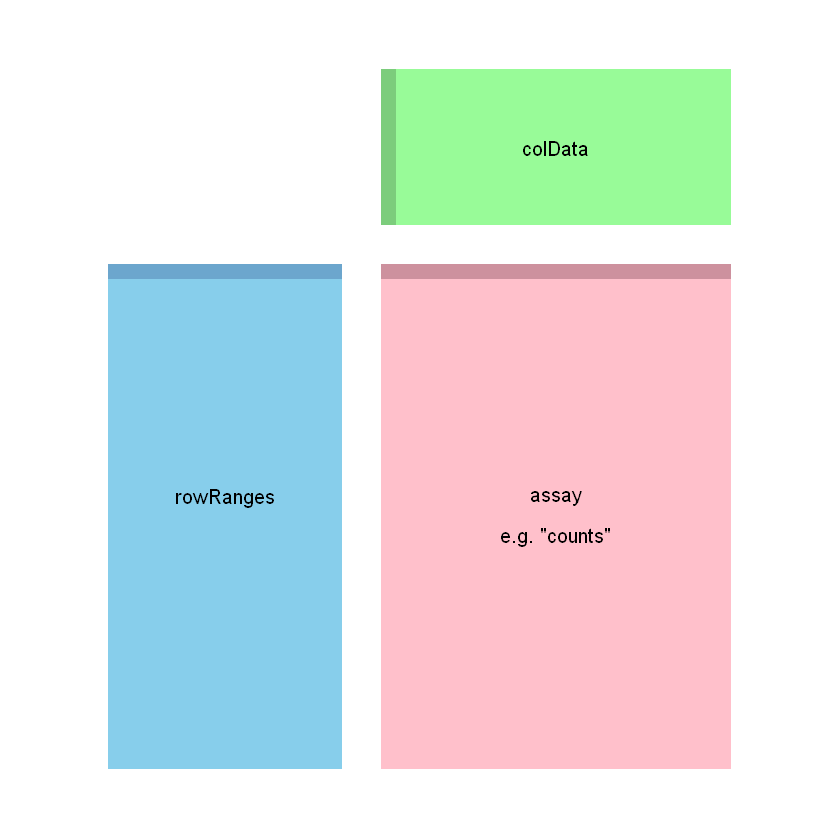

In [8]:
## ----sumexp, echo=FALSE--------------------------------------------------
par(mar=c(0,0,0,0))
plot(1,1,xlim=c(0,100),ylim=c(0,100),bty="n",
     type="n",xlab="",ylab="",xaxt="n",yaxt="n")
polygon(c(45,90,90,45),c(5,5,70,70),col="pink",border=NA)
polygon(c(45,90,90,45),c(68,68,70,70),col="pink3",border=NA)
text(67.5,40,"assay")
text(67.5,35,'e.g. "counts"')
polygon(c(10,40,40,10),c(5,5,70,70),col="skyblue",border=NA)
polygon(c(10,40,40,10),c(68,68,70,70),col="skyblue3",border=NA)
text(25,40,"rowRanges")
polygon(c(45,90,90,45),c(75,75,95,95),col="palegreen",border=NA)
polygon(c(45,47,47,45),c(75,75,95,95),col="palegreen3",border=NA)
text(67.5,85,"colData")

print("Summarized Experiment")

In [ ]:
se
dim(se)
assayNames(se)

The *rowRanges*, when printed, only shows the first GRanges, and tells us there are 19 more elements:

In [ ]:
print("Row summary")
rowRanges(se)

The rowRanges also contains metadata about the construction of the gene model in the metadata slot. Here we use a helpful R function, str, to display the metadata compactly:

In [ ]:
str(metadata(rowRanges(se)))

# column Data
colData(se)

In [ ]:
head(assay(se), 5)
colSums(assay(se))

In [ ]:
colData(se) <- DataFrame(sampleTable)
colData(se)

The colData slot, so far empty, should contain all the metadata. Because we used a column of sampleTable to produce the bamfiles vector, we know the columns of se are in the same order as the rows of sampleTable. We can assign the sampleTable as the colData of the summarized experiment, by converting it into a DataFrame and using the assignment function:

### Branching point

At this point, we have counted the fragments which overlap the genes in the gene model we specified. This is a branching point where we could use a variety of Bioconductor packages for exploration and differential expression of the count data, including edgeR (M. D. Robinson, McCarthy, and Smyth 2009), limma with the voom method (Law et al. 2014), DSS (H. Wu, Wang, and Wu 2013), EBSeq (Leng et al. 2013) and baySeq (Hardcastle and Kelly 2010). Schurch et al. (2016) compared performance of different statistical methods for RNA-seq using a large number of biological replicates and can help users to decide which tools make sense to use, and how many biological replicates are necessary to obtain a certain sensitivity. We will continue using DESeq2 (Love, Huber, and Anders 2014). The SummarizedExperiment object is all we need to start our analysis. In the following section we will show how to use it to create the data object used by DESeq2.

In [ ]:
se$cell
se$dex

**Note:** it is prefered in R that the first level of a factor be the reference level (e.g. control, or untreated samples), so we can relevel the dex factor like so:

In [ ]:
## ----sedex---------------------------------------------------------------
library("magrittr")
se$dex %<>% relevel("untrt")
se$dex

%<>% is the compound assignment pipe-operator from the magrittr package, the above line of code is a concise way of saying

### Starting from summarized expriment

We now use R’s data command to load a prepared SummarizedExperiment that was generated from the publicly available sequencing data files associated with Himes et al. (2014), described above. The steps we used to produce this object were equivalent to those you worked through in the previous sections, except that we used all the reads and all the genes. For more details on the exact steps used to create this object, type vignette("airway") into your R session

In [ ]:
## ----explaincmpass, eval = FALSE-----------------------------------------
## se$dex <- relevel(se$dex, "untrt")

## ------------------------------------------------------------------------
data("airway")
se <- airway

## ------------------------------------------------------------------------
se$dex %<>% relevel("untrt")
se$dex

## ------------------------------------------------------------------------
round( colSums(assay(se)) / 1e6, 1 )

## ------------------------------------------------------------------------
colData(se)


Here we see that this object already contains an informative colData slot – because we have already prepared it for you, as described in the airway vignette. However, when you work with your own data, you will have to add the pertinent sample / phenotypic information for the experiment at this stage. We highly recommend keeping this information in a comma-separated value (CSV) or tab-separated value (TSV) file, which can be exported from an Excel spreadsheet, and the assign this to the colData slot, making sure that the rows correspond to the columns of the SummarizedExperiment. We made sure of this correspondence earlier by specifying the BAM files using a column of the sample table.

Once we have our fully annotated SummarizedExperiment object, we can construct a DESeqDataSet object from it that will then form the starting point of the analysis. We add an appropriate design for the analysis

### Starting from count matrices

In this section, we will show how to build an DESeqDataSet supposing we only have a count matrix and a table of sample information.

**Note:** if you have prepared a SummarizedExperiment you should skip this section. While the previous section would be used to construct a DESeqDataSet from a SummarizedExperiment, here we first extract the individual object (count matrix and sample info) from the SummarizedExperiment in order to build it back up into a new object – only for demonstration purposes. In practice, the count matrix would either be read in from a file or perhaps generated by an R function like featureCounts from the Rsubread package (Liao, Smyth, and Shi 2014).

The information in a SummarizedExperiment object can be accessed with accessor functions. For example, to see the actual data, i.e., here, the fragment counts, we use the assay function. (The head function restricts the output to the first few lines.)

In [ ]:
## ------------------------------------------------------------------------
library("DESeq2")

## ------------------------------------------------------------------------
dds <- DESeqDataSet(se, design = ~ cell + dex)

## ------------------------------------------------------------------------
countdata <- assay(se)
head(countdata, 3)


In this count matrix, each row represents an Ensembl gene, each column a sequenced RNA library, and the values give the raw numbers of fragments that were uniquely assigned to the respective gene in each library. We also have information on each of the samples (the columns of the count matrix). If you’ve counted reads with some other software, it is very important to check that the columns of the count matrix correspond to the rows of the sample information table.

In [ ]:
coldata <- colData(se)

We now have all the ingredients to prepare our data object in a form that is suitable for analysis, namely:
    * countdata: a table with the fragment counts
    * coldata: a table with information about the samples

To now construct the DESeqDataSet object from the matrix of counts and the sample information table, we use:

In [ ]:
## ------------------------------------------------------------------------
ddsMat <- DESeqDataSetFromMatrix(countData = countdata,
                                  colData = coldata,
                                  design = ~ cell + dex)


We will continue with the object generated from the SummarizedExperiment section.

## Exploratory analysis and visualization

There are two separate paths in this workflow; the one we will see first involves transformations of the counts in order to visually explore sample relationships. In the second part, we will go back to the original raw counts for statistical testing. This is critical because the statistical testing methods rely on original count data (not scaled or transformed) for calculating the precision of measurements.

### Pre Filtering the dataset

The count matrix with the DESeqDataSet contains many rows with only zeros, and additionally many rows with only a few fragments total. In order to reduce the size of the object, and to increase the speed of our functions, we can remove the rows that have no or nearly no information about the amount of gene expression. Here we apply the most minimal filtering rule: removing rows of the DESeqDataSet that have no counts, or only a single count across all samples. Additional weighting/filtering to improve power is applied at a later step in the workflow.

In [ ]:
nrow(dds)
dds <- dds[ rowSums(counts(dds)) > 1, ]
nrow(dds)


### The rlog and variance stabilizing transformations

Many common statistical methods for exploratory analysis of multidimensional data, for example clustering and principal components analysis (PCA), work best for data that generally has the same range of variance at different ranges of the mean values. When the expected amount of variance is approximately the same across different mean values, the data is said to be homoskedastic. For RNA-seq counts, however, the expected variance grows with the mean. For example, if one performs PCA directly on a matrix of counts or normalized counts (e.g. correcting for differences in sequencing depth), the resulting plot typically depends mostly on the genes with highest counts because they show the largest absolute differences between samples. A simple and often used strategy to avoid this is to take the logarithm of the normalized count values plus a pseudocount of 1; however, depending on the choice of pseudocount, now the genes with the very lowest counts will contribute a great deal of noise to the resulting plot, because taking the logarithm of small counts actually inflates their variance. We can quickly show this property of counts with some simulated data (here, Poisson counts with a range of lambda from 0.1 to 100). We plot the standard deviation of each row (genes) against the mean:

In [ ]:
## ----meanSdCts-----------------------------------------------------------
lambda <- 10^seq(from = -1, to = 2, length = 1000)
cts <- matrix(rpois(1000*100, lambda), ncol = 100)
library("vsn")
meanSdPlot(cts, ranks = FALSE)


Logarithm-transformed counts:

In [ ]:
## ----meanSdLogCts--------------------------------------------------------
log.cts.one <- log2(cts + 1)
meanSdPlot(log.cts.one, ranks = FALSE)


The logarithm with a small pseudocount amplifies differences when the values are close to 0. The low count genes with low signal-to-noise ratio will overly contribute to sample-sample distances and PCA plots.

As a solution, DESeq2 offers two transformations for count data that stabilize the variance across the mean: the regularized-logarithm transformation or rlog (Love, Huber, and Anders 2014), and the variance stabilizing transformation (VST) for negative binomial data with a dispersion-mean trend (Anders and Huber 2010), implemented in the vst function.

For genes with high counts, the rlog and VST will give similar result to the ordinary log2 transformation of normalized counts. For genes with lower counts, however, the values are shrunken towards the genes’ averages across all samples. The rlog-transformed or VST data then becomes approximately homoskedastic, and can be used directly for computing distances between samples, making PCA plots, or as input to downstream methods which perform best with homoskedastic data.


**Which transformation to choose?** The rlog tends to work well on small datasets (n < 30), sometimes outperforming the VST when there is a large range of sequencing depth across samples (an order of magnitude difference). The VST is much faster to compute and is less sensitive to high count outliers than the rlog. We therefore recommend the VST for large datasets (hundreds of samples). You can perform both transformations and compare the meanSdPlot or PCA plots generated, as described below.

Note that the two transformations offered by DESeq2 are provided for applications other than differential testing. For differential testing we recommend the DESeq function applied to raw counts, as described later in this workflow, which also takes into account the dependence of the variance of counts on the mean value during the dispersion estimation step.

The function rlog returns an object based on the SummarizedExperiment class that contains the rlog-transformed values in its assay slot.

In [ ]:
## ----rlog----------------------------------------------------------------
rld <- rlog(dds, blind = FALSE)
head(assay(rld), 3)

The function *vst* returns a similar object

In [ ]:
print("VST output:")
## ----vst-----------------------------------------------------------------
vsd <- vst(dds, blind = FALSE)
head(assay(vsd), 3)

In the above function calls, we specified blind = FALSE, which means that differences between cell lines and treatment (the variables in the design) will not contribute to the expected variance-mean trend of the experiment. The experimental design is not used directly in the transformation, only in estimating the global amount of variability in the counts. For a fully unsupervised transformation, one can set blind = TRUE (which is the default).

To show the effect of the transformation, in the figure below we plot the first sample against the second, first simply using the log2 function (after adding 1, to avoid taking the log of zero), and then using the rlog- and VST-transformed values. For the log2 approach, we need to first estimate size factors to account for sequencing depth, and then specify normalized=TRUE. Sequencing depth correction is done automatically for the rlog and the vst.

In [ ]:
## ----rldplot, fig.width = 6, fig.height = 2.5----------------------------
library("dplyr")
library("ggplot2")

dds <- estimateSizeFactors(dds)

df <- bind_rows(
  as_data_frame(log2(counts(dds, normalized=TRUE)[, 1:2]+1)) %>%
         mutate(transformation = "log2(x + 1)"),
  as_data_frame(assay(rld)[, 1:2]) %>% mutate(transformation = "rlog"),
  as_data_frame(assay(vsd)[, 1:2]) %>% mutate(transformation = "vst"))
  
colnames(df)[1:2] <- c("x", "y")  

ggplot(df, aes(x = x, y = y)) + geom_hex(bins = 80) +
  coord_fixed() + facet_grid( . ~ transformation)  

**Scatterplot of transformed counts from two samples.** 
Shown are scatterplots using the log2 transform of normalized counts (left), using the rlog (middle), and using the VST (right). While the rlog is on roughly the same scale as the log2 counts, the VST has a upward shift for the smaller values. It is the differences between samples (deviation from y=x in these scatterplots) which will contribute to the distance calculations and the PCA plot.

We can see how genes with low counts (bottom left-hand corner) seem to be excessively variable on the ordinary logarithmic scale, while the rlog transform and VST compress differences for the low count genes for which the data provide little information about differential expression.

### Sample Distance

A useful first step in an RNA-seq analysis is often to assess overall similarity between samples: Which samples are similar to each other, which are different? Does this fit to the expectation from the experiment’s design?

We use the R function dist to calculate the Euclidean distance between samples. To ensure we have a roughly equal contribution from all genes, we use it on the rlog-transformed data. We need to transpose the matrix of values using t, because the dist function expects the different samples to be rows of its argument, and different dimensions (here, genes) to be columns.

In [ ]:
## ------------------------------------------------------------------------
sampleDists <- dist(t(assay(rld)))
sampleDists

We visualize the distances in a heatmap in a figure below, using the function pheatmap from the pheatmap package.

In [ ]:
## ------------------------------------------------------------------------
library("pheatmap")
library("RColorBrewer")

## ----distheatmap, fig.width = 6.1, fig.height = 4.5----------------------
sampleDistMatrix <- as.matrix( sampleDists )
rownames(sampleDistMatrix) <- paste( rld$dex, rld$cell, sep = " - " )
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors)

**Heatmap of sample-to-sample distances using the rlog-transformed values.**

Note that we have changed the row names of the distance matrix to contain treatment type and patient number instead of sample ID, so that we have all this information in view when looking at the heatmap.


Another option for calculating sample distances is to use the Poisson Distance (Witten 2011), implemented in the PoiClaClu package. This measure of dissimilarity between counts also takes the inherent variance structure of counts into consideration when calculating the distances between samples. The PoissonDistance function takes the original count matrix (not normalized) with samples as rows instead of columns, so we need to transpose the counts in dds.

In [ ]:
## ------------------------------------------------------------------------
library("PoiClaClu")
poisd <- PoissonDistance(t(counts(dds)))

## ----poisdistheatmap, fig.width = 6.1, fig.height = 4.5------------------
samplePoisDistMatrix <- as.matrix( poisd$dd )
rownames(samplePoisDistMatrix) <- paste( rld$dex, rld$cell, sep=" - " )
colnames(samplePoisDistMatrix) <- NULL
pheatmap(samplePoisDistMatrix,
         clustering_distance_rows = poisd$dd,
         clustering_distance_cols = poisd$dd,
         col = colors)


**Heatmap of sample-to-sample distances using the Poisson Distance.**

### PCA plot

Another way to visualize sample-to-sample distances is a principal components analysis (PCA). In this ordination method, the data points (here, the samples) are projected onto the 2D plane such that they spread out in the two directions that explain most of the differences (figure below). The x-axis is the direction that separates the data points the most. The values of the samples in this direction are written PC1. The y-axis is a direction (it must be orthogonal to the first direction) that separates the data the second most. The values of the samples in this direction are written PC2. The percent of the total variance that is contained in the direction is printed in the axis label. Note that these percentages do not add to 100%, because there are more dimensions that contain the remaining variance (although each of these remaining dimensions will explain less than the two that we see).

In [ ]:
## ----plotpca, fig.width=6, fig.height=4.5--------------------------------
plotPCA(rld, intgroup = c("dex", "cell"))


**PCA plot using the rlog-transformed values.** Each unique combination of treatment and cell line is given its own color.

Here, we have used the function plotPCA that comes with DESeq2. The two terms specified by intgroup are the interesting groups for labeling the samples; they tell the function to use them to choose colors. We can also build the PCA plot from scratch using the ggplot2 package (Wickham 2009). This is done by asking the plotPCA function to return the data used for plotting rather than building the plot. See the ggplot2 documentation for more details on using ggplot.

In [ ]:
## ------------------------------------------------------------------------
pcaData <- plotPCA(rld, intgroup = c( "dex", "cell"), returnData = TRUE)
pcaData
percentVar <- round(100 * attr(pcaData, "percentVar"))

## ----ggplotpca, fig.width=6, fig.height=4.5------------------------------
ggplot(pcaData, aes(x = PC1, y = PC2, color = dex, shape = cell)) +
  geom_point(size =3) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  coord_fixed()


**PCA plot using the rlog-transformed values with custom ggplot2 code.** Here we specify cell line (plotting symbol) and dexamethasone treatment (color).

From the PCA plot, we see that the differences between cells (the different plotting shapes) are considerable, though not stronger than the differences due to treatment with dexamethasone (red vs blue color). This shows why it will be important to account for this in differential testing by using a paired design (“paired”, because each dex treated sample is paired with one untreated sample from the same cell line). We are already set up for this design by assigning the formula ~ cell + dex earlier.

### MDS plot

Another plot, very similar to the PCA plot, can be made using the multidimensional scaling (MDS) function in base R. This is useful when we don’t have a matrix of data, but only a matrix of distances. Here we compute the MDS for the distances calculated from the rlog transformed counts and plot these in a figure below.

In [ ]:
## ----mdsrlog, fig.width=6, fig.height=4.5--------------------------------
mds <- as.data.frame(colData(rld))  %>%
         cbind(cmdscale(sampleDistMatrix))
ggplot(mds, aes(x = `1`, y = `2`, color = dex, shape = cell)) +
  geom_point(size = 3) + coord_fixed()


#### MDS plot using rlog-transformed vlaues.

In a figure below we show the same plot for the PoissonDistance:

In [ ]:

## ----mdspois, fig.width=6, fig.height=4.5--------------------------------
mdsPois <- as.data.frame(colData(dds)) %>%
   cbind(cmdscale(samplePoisDistMatrix))
ggplot(mdsPois, aes(x = `1`, y = `2`, color = dex, shape = cell)) +
  geom_point(size = 3) + coord_fixed()


**MDS plot using the *Poisson Distance* **

## Differentital expression analysis

### Running the differential expression pipeline

As we have already specified an experimental design when we created the DESeqDataSet, we can run the differential expression pipeline on the raw counts with a single call to the function DESeq:

In [ ]:
## ----airwayDE------------------------------------------------------------
dds <- DESeq(dds)

This function will print out a message for the various steps it performs. These are described in more detail in the manual page for DESeq, which can be accessed by typing ?DESeq. Briefly these are: the estimation of size factors (controlling for differences in the sequencing depth of the samples), the estimation of dispersion values for each gene, and fitting a generalized linear model.

A DESeqDataSet is returned that contains all the fitted parameters within it, and the following section describes how to extract out results tables of interest from this object.

### Building the results table

Calling results without any arguments will extract the estimated log2 fold changes and p values for the last variable in the design formula. If there are more than 2 levels for this variable, results will extract the results table for a comparison of the last level over the first level. The comparison is printed at the top of the output: dex trt vs untrt.

In [ ]:
res <- results(dds)
res

mcols(res, use.names = TRUE)


The first column, baseMean, is a just the average of the normalized count values, divided by the size factors, taken over all samples in the DESeqDataSet. The remaining four columns refer to a specific contrast, namely the comparison of the trt level over the untrt level for the factor variable dex. We will find out below how to obtain other contrasts.

The column log2FoldChange is the effect size estimate. It tells us how much the gene’s expression seems to have changed due to treatment with dexamethasone in comparison to untreated samples. This value is reported on a logarithmic scale to base 2: for example, a log2 fold change of 1.5 means that the gene’s expression is increased by a multiplicative factor of 21.5 ≈ 2.82.

Of course, this estimate has an uncertainty associated with it, which is available in the column lfcSE, the standard error estimate for the log2 fold change estimate. We can also express the uncertainty of a particular effect size estimate as the result of a statistical test. The purpose of a test for differential expression is to test whether the data provides sufficient evidence to conclude that this value is really different from zero. DESeq2 performs for each gene a hypothesis test to see whether evidence is sufficient to decide against the null hypothesis that there is zero effect of the treatment on the gene and that the observed difference between treatment and control was merely caused by experimental variability (i.e., the type of variability that you can expect between different samples in the same treatment group). As usual in statistics, the result of this test is reported as a p value, and it is found in the column pvalue. Remember that a p value indicates the probability that a fold change as strong as the observed one, or even stronger, would be seen under the situation described by the null hypothesis.


We can also summarize the results with the following line of code, which reports some additional information, that will be covered in later sections.

In [ ]:
summary(res)

Note that there are many genes with differential expression due to dexamethasone treatment at the FDR level of 10%. This makes sense, as the smooth muscle cells of the airway are known to react to glucocorticoid steroids. However, there are two ways to be more strict about which set of genes are considered significant:

* lower the false discovery rate threshold (the threshold on padj in the results table)
* raise the log2 fold change threshold from 0 using the lfcThreshold argument of results

If we lower the false discovery rate threshold, we should also inform the results() function about it, so that the function can use this threshold for the optimal independent filtering that it performs:

In [ ]:
## ------------------------------------------------------------------------
res.05 <- results(dds, alpha = 0.05)
table(res.05$padj < 0.05)


If we want to raise the log2 fold change threshold, so that we test for genes that show more substantial changes due to treatment, we simply supply a value on the log2 scale. For example, by specifying lfcThreshold = 1, we test for genes that show significant effects of treatment on gene counts more than doubling or less than halving, because 21 = 2.

In [ ]:
## ------------------------------------------------------------------------
resLFC1 <- results(dds, lfcThreshold=1)
table(resLFC1$padj < 0.1)


Sometimes a subset of the p values in res will be NA (“not available”). This is DESeq’s way of reporting that all counts for this gene were zero, and hence no test was applied. In addition, p values can be assigned NA if the gene was excluded from analysis because it contained an extreme count outlier. For more information, see the outlier detection section of the DESeq2 vignette.

If you use the results from an R analysis package in published research, you can find the proper citation for the software by typing citation("pkgName"), where you would substitute the name of the package for pkgName. Citing methods papers helps to support and reward the individuals who put time into open source software for genomic data analysis.

### Other comaprisions

In general, the results for a comparison of any two levels of a variable can be extracted using the contrast argument to results. The user should specify three values: the name of the variable, the name of the level for the numerator, and the name of the level for the denominator. Here we extract results for the log2 of the fold change of one cell line over another:

In [ ]:
results(dds, contrast = c("cell", "N061011", "N61311"))

If results for an interaction term are desired, the name argument of results should be used. Please see the help for the results function for more details.

### Multiple testing

In high-throughput biology, we are careful to not use the p values directly as evidence against the null, but to correct for multiple testing. What would happen if we were to simply threshold the p values at a low value, say 0.05? There are 5676 genes with a p value below 0.05 among the 29391 genes for which the test succeeded in reporting a p value:

In [ ]:
## ----sumres--------------------------------------------------------------
sum(res$pvalue < 0.05, na.rm=TRUE)
sum(!is.na(res$pvalue))

Now, assume for a moment that the null hypothesis is true for all genes, i.e., no gene is affected by the treatment with dexamethasone. Then, by the definition of the p value, we expect up to 5% of the genes to have a p value below 0.05. This amounts to 1470 genes. If we just considered the list of genes with a p value below 0.05 as differentially expressed, this list should therefore be expected to contain up to 1470 / 5676 = 26% false positives.

DESeq2 uses the Benjamini-Hochberg (BH) adjustment (Benjamini and Hochberg 1995) as implemented in the base R p.adjust function; in brief, this method calculates for each gene an adjusted p value that answers the following question: if one called significant all genes with an adjusted p value less than or equal to this gene’s adjusted p value threshold, what would be the fraction of false positives (the false discovery rate, FDR) among them, in the sense of the calculation outlined above? These values, called the BH-adjusted p values, are given in the column padj of the res object.
The FDR is a useful statistic for many high-throughput experiments, as we are often interested in reporting or focusing on a set of interesting genes, and we would like to put an upper bound on the percent of false positives in this set.

Hence, if we consider a fraction of 10% false positives acceptable, we can consider all genes with an adjusted p value below 10% = 0.1 as significant. How many such genes are there?

In [ ]:
sum(res$padj < 0.1, na.rm=TRUE)

We subset the results table to these genes and then sort it by the log2 fold change estimate to get the significant genes with the strongest down-regulation:

In [ ]:
resSig <- subset(res, padj < 0.1)
head(resSig[ order(resSig$log2FoldChange), ])


And the strongest up-regulation:

In [ ]:
## ------------------------------------------------------------------------
head(resSig[ order(resSig$log2FoldChange, decreasing = TRUE), ])

## Plotting Results

A quick way to visualize the counts for a particular gene is to use the plotCounts function that takes as arguments the DESeqDataSet, a gene name, and the group over which to plot the counts (figure below).

In [ ]:
## ----plotcounts----------------------------------------------------------
topGene <- rownames(res)[which.min(res$padj)]
plotCounts(dds, gene = topGene, intgroup=c("dex"))

**Normalized counts for a single gene over treatment group.**

We can also make custom plots using the ggplot function from the ggplot2 package (figures below).

In [ ]:
library("ggbeeswarm")
geneCounts <- plotCounts(dds, gene = topGene, intgroup = c("dex","cell"),
                         returnData = TRUE)
ggplot(geneCounts, aes(x = dex, y = count, color = cell)) +
  scale_y_log10() +  geom_beeswarm(cex = 3)

In [ ]:
## ----ggplotcountsgroup, fig.width = 4, fig.height = 3--------------------
ggplot(geneCounts, aes(x = dex, y = count, color = cell, group = cell)) +
  scale_y_log10() + geom_point(size = 3) + geom_line()


**Normalized counts with lines connecting cell lines.**
Note that the DESeq test actually takes into account the cell line effect, so this figure more closely depicts the difference being tested.

An MA-plot (R. Dudoit et al. 2002) provides a useful overview for an experiment with a two-group comparison (figure below).

In [ ]:
## ----plotma--------------------------------------------------------------
plotMA(res, ylim = c(-5, 5))

**An MA-plot of changes induced by treatment.** 
The log2 fold change for a particular comparison is plotted on the y-axis and the average of the counts normalized by size factor is shown on the x-axis (“M” for minus, because a log ratio is equal to log minus log, and “A” for average). Each gene is represented with a dot. Genes with an adjusted p value below a threshold (here 0.1, the default) are shown in red.

The DESeq2 package uses statistical techniques to moderate log2 fold changes from genes with very low counts and highly variable counts, as can be seen by the narrowing of the vertical spread of points on the left side of the MA-plot. For a detailed explanation of the rationale of moderated fold changes, please see the DESeq2 paper (Love, Huber, and Anders 2014). This plot demonstrates that only genes with a large average normalized count contain sufficient information to yield a significant call.

We can also make an MA-plot for the results table in which we raised the log2 fold change threshold (figure below). We can label individual points on the MA-plot as well. Here we use the with R function to plot a circle and text for a selected row of the results object. Within the with function, only the baseMean and log2FoldChange values for the selected rows of res are used.

In [ ]:
## ----plotmalabel---------------------------------------------------------
plotMA(resLFC1, ylim = c(-5,5))
topGene <- rownames(resLFC1)[which.min(resLFC1$padj)]
with(resLFC1[topGene, ], {
  points(baseMean, log2FoldChange, col="dodgerblue", cex=2, lwd=2)
  text(baseMean, log2FoldChange, topGene, pos=2, col="dodgerblue")
})

**An MA-plot of a test for large log2 fold changes.** The red points indicate genes for which the log2 fold change was significantly higher than 1 or less than -1 (treatment resulting in more than doubling or less than halving of the normalized counts). The point circled in blue indicates the gene with the lowest adjusted p value.

Another useful diagnostic plot is the histogram of the p values (figure below). This plot is best formed by excluding genes with very small counts, which otherwise generate spikes in the histogram.

In [ ]:
hist(res$pvalue[res$baseMean > 1], breaks = 0:20/20,
     col = "grey50", border = "white")

**Histogram of p values for genes with mean normalized count larger than 1.**

### Gene clustering

In the sample distance heatmap made previously, the dendrogram at the side shows us a hierarchical clustering of the samples. Such a clustering can also be performed for the genes. Since the clustering is only relevant for genes that actually carry a signal, one usually would only cluster a subset of the most highly variable genes. Here, for demonstration, let us select the 20 genes with the highest variance across samples. We will work with the rlog transformed counts:


In [ ]:
library("genefilter")
topVarGenes <- head(order(rowVars(assay(rld)), decreasing = TRUE), 20)

The heatmap becomes more interesting if we do not look at absolute expression strength but rather at the amount by which each gene deviates in a specific sample from the gene’s average across all samples. Hence, we center each genes’ values across samples, and plot a heatmap (figure below). We provide a data.frame that instructs the pheatmap function how to label the columns.

In [ ]:
mat  <- assay(rld)[ topVarGenes, ]
mat  <- mat - rowMeans(mat)
anno <- as.data.frame(colData(rld)[, c("cell","dex")])
pheatmap(mat, annotation_col = anno)

**Heatmap of relative rlog-transformed values across samples.** 
Treatment status and cell line information are shown with colored bars at the top of the heatmap. Blocks of genes that covary across patients. Note that a set of genes at the top of the heatmap are separating the N061011 cell line from the others. In the center of the heatmap, we see a set of genes for which the dexamethasone treated samples have higher gene expression.

**Independent Filtering**

The MA plot highlights an important property of RNA-seq data. For weakly expressed genes, we have no chance of seeing differential expression, because the low read counts suffer from such high Poisson noise that any biological effect is drowned in the uncertainties from the sampling at a low rate. We can also show this by examining the ratio of small p values (say, less than 0.05) for genes binned by mean normalized count. We will use the results table subjected to the threshold to show what this looks like in a case when there are few tests with small p value.

In the following code chunk, we create bins using the quantile function, bin the genes by base mean using cut, rename the levels of the bins using the middle point, calculate the ratio of p values less than 0.05 for each bin, and finally plot these ratios (figure below).

In [ ]:
## ----sensitivityovermean, fig.width=6------------------------------------
qs <- c(0, quantile(resLFC1$baseMean[resLFC1$baseMean > 0], 0:6/6))
bins <- cut(resLFC1$baseMean, qs)
levels(bins) <- paste0("~", round(signif((qs[-1] + qs[-length(qs)])/2, 2)))
fractionSig <- tapply(resLFC1$pvalue, bins, function(p)
                          mean(p < .05, na.rm = TRUE))
barplot(fractionSig, xlab = "mean normalized count",
                     ylab = "fraction of small p values")

The ratio of small p values for genes binned by mean normalized count. The p values are from a test of log2 fold change greater than 1 or less than -1. This plot demonstrates that genes with very low mean count have little or no power, and are best excluded from testing.

At first sight, there may seem to be little benefit in filtering out these genes. After all, the test found them to be non-significant anyway. However, these genes have an influence on the multiple testing adjustment, whose performance improves if such genes are removed. By removing the low count genes from the input to the FDR procedure, we can find more genes to be significant among those that we keep, and so improved the power of our test. This approach is known as independent filtering.

The DESeq2 software automatically performs independent filtering that maximizes the number of genes with adjusted p value less than a critical value (by default, alpha is set to 0.1). This automatic independent filtering is performed by, and can be controlled by, the results function.

The term independent highlights an important caveat. Such filtering is permissible only if the statistic that we filter on (here the mean of normalized counts across all samples) is independent of the actual test statistic (the p value) under the null hypothesis. Otherwise, the filtering would invalidate the test and consequently the assumptions of the BH procedure. The independent filtering software used inside DESeq2 comes from the genefilter package, that contains a reference to a paper describing the statistical foundation for independent filtering (Bourgon, Gentleman, and Huber 2010).

## Annotating and exporting results

Our result table so far only contains the Ensembl gene IDs, but alternative gene names may be more informative for interpretation. Bioconductor’s annotation packages help with mapping various ID schemes to each other. We load the AnnotationDbi package and the annotation package org.Hs.eg.db:

In [ ]:
## ------------------------------------------------------------------------
library("AnnotationDbi")
library("org.Hs.eg.db")

This is the organism annotation package (“org”) for Homo sapiens (“Hs”), organized as an AnnotationDbi database package (“db”), using Entrez Gene IDs (“eg”) as primary key. To get a list of all available key types, use

In [ ]:
## ------------------------------------------------------------------------
columns(org.Hs.eg.db)

We can use the mapIds function to add individual columns to our results table. We provide the row names of our results table as a key, and specify that keytype=ENSEMBL. The column argument tells the mapIds function which information we want, and the multiVals argument tells the function what to do if there are multiple possible values for a single input value. Here we ask to just give us back the first one that occurs in the database. To add the gene symbol and Entrez ID, we call mapIds twice.


In [ ]:
## ------------------------------------------------------------------------
res$symbol <- mapIds(org.Hs.eg.db,
                     keys=row.names(res),
                     column="SYMBOL",
                     keytype="ENSEMBL",
                     multiVals="first")
res$entrez <- mapIds(org.Hs.eg.db,
                     keys=row.names(res),
                     column="ENTREZID",
                     keytype="ENSEMBL",
                     multiVals="first")

### Exporting results

You can easily save the results table in a CSV file that you can then share or load with a spreadsheet program such as Excel. The call to as.data.frame is necessary to convert the DataFrame object (IRanges package) to a data.frame object that can be processed by write.csv. Here, we take just the top 100 genes for demonstration.

In [ ]:
## to export the file

# resOrderedDF <- as.data.frame(resOrdered)[1:100, ]
# write.csv(resOrderedDF, file = "results.csv")

resOrdered <- res[order(res$padj),]
head(resOrdered)

### Plotting fold changes in genomic space

If we have used the summarizeOverlaps function to count the reads, then our DESeqDataSet object is built on top of ready-to-use Bioconductor objects specifying the genomic coordinates of the genes. We can therefore easily plot our differential expression results in genomic space. While the results function by default returns a DataFrame, using the format argument, we can ask for GRanges or GRangesList output.

In [ ]:
## ------------------------------------------------------------------------
resGR <- results(dds, lfcThreshold = 1, format = "GRanges")
resGR


We need to add the symbol again for labeling the genes on the plot:

In [ ]:
resGR$symbol <- mapIds(org.Hs.eg.db, names(resGR), "SYMBOL", "ENSEMBL")

We will use the Gviz package for plotting the GRanges and associated metadata: the log fold changes due to dexamethasone treatment.

In [ ]:
library("Gviz")

The following code chunk specifies a window of 1 million base pairs upstream and downstream from the gene with the smallest p value. We create a subset of our full results, for genes within the window. We add the gene symbol as a name if the symbol exists and is not duplicated in our subset.

In [ ]:
## ------------------------------------------------------------------------
window <- resGR[topGene] + 1e6
strand(window) <- "*"
resGRsub <- resGR[resGR %over% window]
naOrDup <- is.na(resGRsub$symbol) | duplicated(resGRsub$symbol)
resGRsub$group <- ifelse(naOrDup, names(resGRsub), resGRsub$symbol)


We create a vector specifying if the genes in this subset had a low value of padj.

In [ ]:
## ------------------------------------------------------------------------
status <- factor(ifelse(resGRsub$padj < 0.1 & !is.na(resGRsub$padj),
                     "sig", "notsig"))

We can then plot the results using Gviz functions (figure below). We create an axis track specifying our location in the genome, a track that will show the genes and their names, colored by significance, and a data track that will draw vertical bars showing the moderated log fold change produced by DESeq2, which we know are only large when the effect is well supported by the information in the counts.

In [ ]:
## ----gvizplot------------------------------------------------------------
options(ucscChromosomeNames = FALSE)
g <- GenomeAxisTrack()
a <- AnnotationTrack(resGRsub, name = "gene ranges", feature = status)
d <- DataTrack(resGRsub, data = "log2FoldChange", baseline = 0,
               type = "h", name = "log2 fold change", strand = "+")
plotTracks(list(g, d, a), groupAnnotation = "group",
           notsig = "grey", sig = "hotpink")


**log2 fold changes in genomic region surrounding the gene with smallest adjusted p value.** 
Genes highlighted in pink have adjusted p value less than 0.1.

## Removing hidden batch effects

Suppose we did not know that there were different cell lines involved in the experiment, only that there was treatment with dexamethasone. The cell line effect on the counts then would represent some hidden and unwanted variation that might be affecting many or all of the genes in the dataset. We can use statistical methods designed for RNA-seq from the sva package (Leek 2014) to detect such groupings of the samples, and then we can add these to the DESeqDataSet design, in order to account for them. The SVA package uses the term surrogate variables for the estimated variables that we want to account for in our analysis. Another package for detecting hidden batches is the RUVSeq package (Risso et al. 2014), with the acronym “Remove Unwanted Variation”.

In [ ]:
## ------------------------------------------------------------------------
library("sva")

Below we obtain a matrix of normalized counts for which the average count across samples is larger than 1. As we described above, we are trying to recover any hidden batch effects, supposing that we do not know the cell line information. So we use a full model matrix with the dex variable, and a reduced, or null, model matrix with only an intercept term. Finally we specify that we want to estimate 2 surrogate variables. For more information read the manual page for the svaseq function by typing *?svaseq*.

In [ ]:
dat  <- counts(dds, normalized = TRUE)
idx  <- rowMeans(dat) > 1
dat  <- dat[idx, ]
mod  <- model.matrix(~ dex, colData(dds))
mod0 <- model.matrix(~   1, colData(dds))
svseq <- svaseq(dat, mod, mod0, n.sv = 2)
svseq$sv


Because we actually do know the cell lines, we can see how well the SVA method did at recovering these variables (figure below).

In [ ]:
par(mfrow = c(2, 1), mar = c(3,5,3,1))
for (i in 1:2) {
  stripchart(svseq$sv[, i] ~ dds$cell, vertical = TRUE, main = paste0("SV", i))
  abline(h = 0)
 }

**Surrogate variables 1 and 2 plotted over cell line.** 
Here, we know the hidden source of variation (cell line), and therefore can see how the SVA procedure is able to identify a source of variation which is correlated with cell line.

Finally, in order to use SVA to remove any effect on the counts from our surrogate variables, we simply add these two surrogate variables as columns to the DESeqDataSet and then add them to the design:

In [ ]:
## ------------------------------------------------------------------------
ddssva <- dds
ddssva$SV1 <- svseq$sv[,1]
ddssva$SV2 <- svseq$sv[,2]
design(ddssva) <- ~ SV1 + SV2 + dex

We could then produce results controlling for surrogate variables by running DESeq with the new design:

In [ ]:
ddssva %<>% DESeq

## Time course experiments

DESeq2 can be used to analyze time course experiments, for example to find those genes that react in a condition-specific manner over time, compared to a set of baseline samples. Here we demonstrate a basic time course analysis with the fission data package, which contains gene counts for an RNA-seq time course of fission yeast (Leong et al. 2014). The yeast were exposed to oxidative stress, and half of the samples contained a deletion of the gene atf21. We use a design formula that models the strain difference at time 0, the difference over time, and any strain-specific differences over time (the interaction term strain:minute).

In [ ]:
## ------------------------------------------------------------------------
library("fission")
data("fission")
ddsTC <- DESeqDataSet(fission, ~ strain + minute + strain:minute)

The following chunk of code performs a likelihood ratio test, where we remove the strain-specific differences over time. Genes with small p values from this test are those which at one or more time points after time 0 showed a strain-specific effect. Note therefore that this will not give small p values to genes that moved up or down over time in the same way in both strains.

In [ ]:
## ----fissionDE-----------------------------------------------------------
ddsTC <- DESeq(ddsTC, test="LRT", reduced = ~ strain + minute)
resTC <- results(ddsTC)
resTC$symbol <- mcols(ddsTC)$symbol
head(resTC[order(resTC$padj),], 4)

This is just one of the tests that can be applied to time series data. Another option would be to model the counts as a smooth function of time, and to include an interaction term of the condition with the smooth function. It is possible to build such a model using spline basis functions within R, and another, more modern approach is using Gaussian processes (Tonner et al. 2017).

We can plot the counts for the groups over time using ggplot2, for the gene with the smallest adjusted p value, testing for condition-dependent time profile and accounting for differences at time 0 (figure below). Keep in mind that the interaction terms are the difference between the two groups at a given time after accounting for the difference at time 0.

In [ ]:
fiss <- plotCounts(ddsTC, which.min(resTC$padj), 
                   intgroup = c("minute","strain"), returnData = TRUE)
ggplot(fiss,
  aes(x = as.numeric(minute), y = count, color = strain, group = strain)) + 
  geom_point() + geom_smooth(se = FALSE, method = "loess") + scale_y_log10()

**Normalized counts for a gene with condition-specific changes over time.**

Wald tests for the log2 fold changes at individual time points can be investigated using the test argument to results:

In [ ]:
## ------------------------------------------------------------------------
resultsNames(ddsTC)
res30 <- results(ddsTC, name="strainmut.minute30", test="Wald")
res30[which.min(resTC$padj),]


We can furthermore cluster significant genes by their profiles. We extract a matrix of the shrunken log2 fold changes using the coef function:

In [ ]:
## ------------------------------------------------------------------------
betas <- coef(ddsTC)
colnames(betas)

We can now plot the log2 fold changes in a heatmap (figure below).

In [ ]:
## ----fissionheatmap------------------------------------------------------
topGenes <- head(order(resTC$padj),20)
mat <- betas[topGenes, -c(1,2)]
thr <- 3 
mat[mat < -thr] <- -thr
mat[mat > thr] <- thr
pheatmap(mat, breaks=seq(from=-thr, to=thr, length=101),
         cluster_col=FALSE)

**Heatmap of log2 fold changes for genes with smallest adjusted p value.**

The bottom set of genes show strong induction of expression for the baseline samples in minutes 15-60 (red boxes in the bottom left corner), but then have slight differences for the mutant strain (shown in the boxes in the bottom right corner).

## Session Information

As the last part of this document, we call the function sessionInfo, which reports the version numbers of R and all the packages used in this session. It is good practice to always keep such a record of this as it will help to track down what has happened in case an R script ceases to work or gives different results because the functions have been changed in a newer version of one of your packages. By including it at the bottom of a script, your reports will become more reproducible.

The session information should also always be included in any emails to the Bioconductor support site along with all code used in the analysis.

In [ ]:
## ------------------------------------------------------------------------
devtools::session_info()

In [12]:
!ls

ERROR: Error in !ls: invalid argument type


In [20]:
system("ls", intern=TRUE) 
getwd()

[1] "Binder"                                   
 [2] "GPL96.annot"                              
 [3] "GSE13425_Norm_Whole.txt"                  
 [4] "GSE7765-GPL96_series_matrix.txt"          
 [5] "Git_upload"                               
 [6] "IntroMicroarray.R"                        
 [7] "Microarray.R"                             
 [8] "RNASeq Data - Bioconductor - Binder.ipynb"
 [9] "RNASeq Data - Bioconductor.ipynb"         
[10] "RNAseq.pdf"                               
[11] "fastq"

[1] "C:/Users/Yash/Desktop/Gene analysis ex"

## Custom styling

In [ ]:
%lsmagic

In [ ]:
from IPython.core.display import HTML
import urllib2
HTML( urllib2.urlopen('http://bit.ly/1Bf5Hft').read() )